# Confinement Time Scaling Analysis

이 노트북은 토카막 confinement time scaling 분석을 위한 전체 워크플로우를 제공합니다.

## 노트북 구조

1. **Part 1: Single Shot Workflow Test** - 하나의 샷을 사용하여 전체 워크플로우를 테스트합니다
   - 샷 선택 및 ODS 로드
   - 파라미터 추출 및 확인
   - 시각화 및 분석

2. **Part 2: Full Dataset Statistical Analysis** - 전체 샷에 대한 통계적 분석을 수행합니다
   - 모든 core_profile 샷에서 파라미터 추출
   - OLS 회귀 분석을 통한 scaling law 지수 도출
   - 결과 시각화 및 물리적 검증

3. **Part 3: Comparison with TS shot and aribitrary shot**

## 초기 설정 및 샷 목록 확인

In [1]:
import vaft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import omas
from omfit_classes.omfit_eqdsk import OMFITgeqdsk

print("Loading available Thomson Scattering shots...")
df = vaft.database.exist_ts_file()
core_profile_shots = df[df['Status'] == 'core_profile']
shot_numbers = core_profile_shots['Shot Number'].values

print(f"\nFound {len(shot_numbers)} shots with core_profile status:")
print(shot_numbers)

Loading available Thomson Scattering shots...
Available Thomson Scattering Shots:

|   Index |   Shot Number | Last Processed             | Status       |
|---------|---------------|----------------------------|--------------|
|       1 |         22027 | 2023-02-02T23:24:20        | invalid      |
|       2 |         39515 | 2024-08-06T11:19:39.748631 | thomson_only |
|       3 |         39906 | 2024-08-06T11:20:05.668157 | core_profile |
|       4 |         39915 | 2024-05-14T16:42:35.439538 | invalid      |
|       5 |         39916 | 2024-07-08T20:11:09.953256 | invalid      |
|       6 |         39917 | 2023-07-05T20:47:14        | thomson_only |
|       7 |         40282 | 2024-08-06T11:20:28.826835 | core_profile |
|       8 |         40323 | 2023-07-28T16:04:09        | core_profile |
|       9 |         40324 | 2023-07-28T16:05:23        | invalid      |
|      10 |         40325 | 2023-07-28T16:06:39        | core_profile |
|      11 |         40326 | 2023-07-28T16:07:55      

In [20]:
test_shot = shot_numbers[1]  # Use first available shot
print(f"\nSelected test shot: {test_shot}")


Selected test shot: 40282


---

# Part 1: Single Shot Workflow Test

하나의 샷을 사용하여 전체 워크플로우를 테스트합니다. 이 섹션에서는:
1. ODS 로드 및 데이터 확인
2. 파라미터 추출 (gen_core_profiles_history 함수 사용)
3. 통계 분석 및 시각화

### 1.1 ODS 로드 및 데이터 확인

In [22]:
shot = 42962
ods=vaft.database.load(shot,'public')

Successfully loaded ODS data for shot: 42962


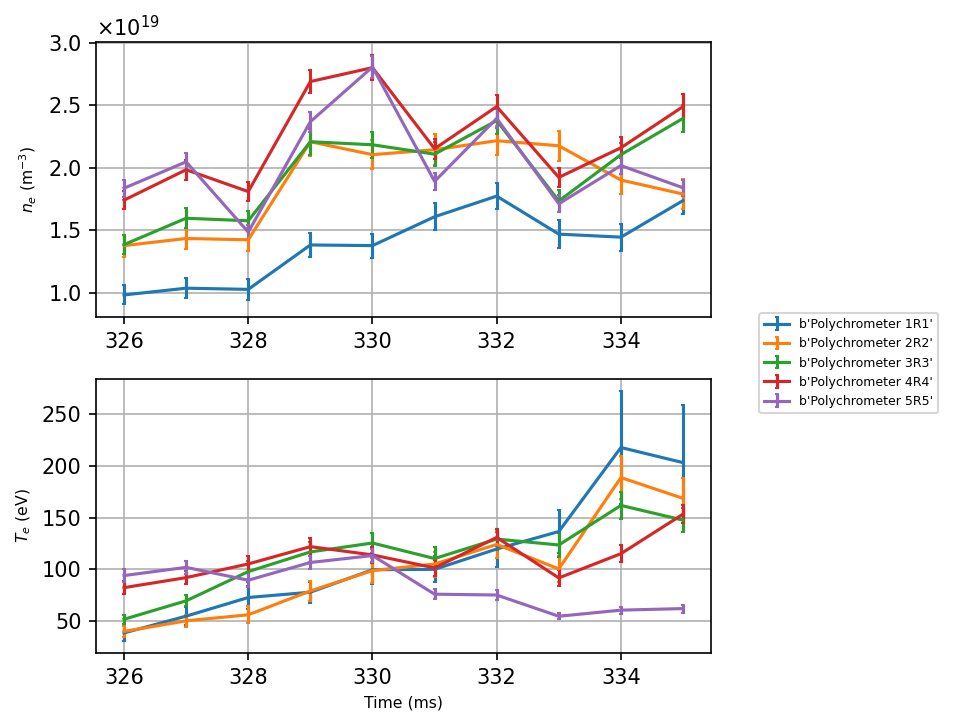

In [23]:
vaft.plot.plot_thomson_time_series(ods)

[INFO] Found 3 fitted core_profiles


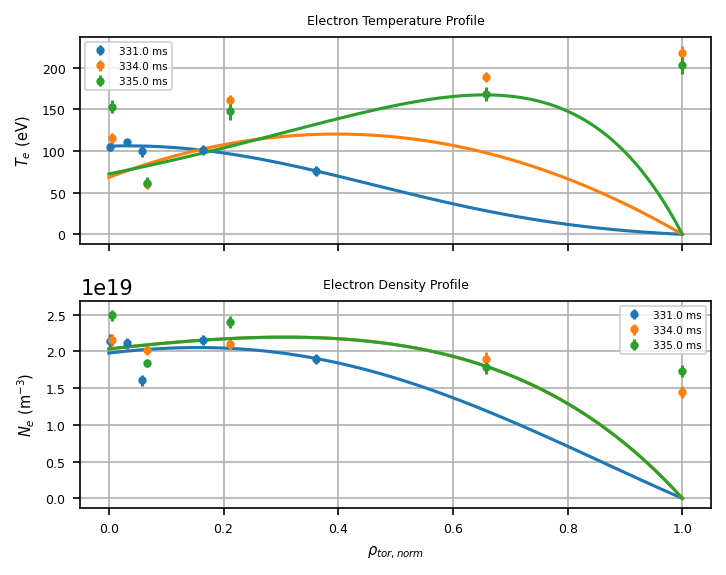

In [39]:
vaft.plot.plot_thomson_profiles(ods)

In [41]:
# Verify data availability
has_equilibrium = 'equilibrium.time_slice' in ods and len(ods['equilibrium.time_slice']) > 0
has_core_profiles = 'core_profiles.profiles_1d' in ods and len(ods['core_profiles.profiles_1d']) > 0

print(f"Equilibrium available: {has_equilibrium}")
print(f"Core profiles available: {has_core_profiles}")

if has_equilibrium:
    n_eq = len(ods['equilibrium.time_slice'])
    eq_time = ods['equilibrium.time_slice'][0].get('time', 0)
    print(f"Number of equilibrium time slices: {n_eq}")
    print(f"First equilibrium time: {eq_time:.4f} s")

if has_core_profiles:
    n_cp = len(ods['core_profiles.profiles_1d'])
    cp_time = ods['core_profiles.profiles_1d'][0].get('time', 0)
    print(f"Number of core profile time slices: {n_cp}")
    print(f"First core profile time: {cp_time:.4f} s")

Equilibrium available: True
Core profiles available: True
Number of equilibrium time slices: 4
First equilibrium time: 0.3310 s
Number of core profile time slices: 3
First core profile time: 0.3310 s


### 1.2 단일 샷 파라미터 추출 및 통계 분석

In [42]:
ods['equilibrium.time_slice'][0]['profiles_2d']['0'].keys()

['b_field_r',
 'b_field_tor',
 'b_field_z',
 'grid',
 'grid_type',
 'phi',
 'psi',
 'r',
 'z']

In [43]:
ods['equilibrium.time_slice'][0]['profiles_1d'].keys()

['area',
 'b_field_average',
 'b_field_max',
 'b_field_min',
 'darea_dpsi',
 'darea_drho_tor',
 'dpressure_dpsi',
 'dpsi_drho_tor',
 'dvolume_dpsi',
 'dvolume_drho_tor',
 'elongation',
 'f',
 'f_df_dpsi',
 'geometric_axis',
 'gm1',
 'gm2',
 'gm5',
 'gm8',
 'gm9',
 'j_tor',
 'phi',
 'pressure',
 'psi',
 'q',
 'r_inboard',
 'r_outboard',
 'rho_tor',
 'rho_tor_norm',
 'squareness_lower_inner',
 'squareness_lower_outer',
 'squareness_upper_inner',
 'squareness_upper_outer',
 'surface',
 'trapped_fraction',
 'triangularity_lower',
 'triangularity_upper',
 'volume']

In [44]:
ods['equilibrium.time_slice'][0]['profiles_2d']['0'].keys()

['b_field_r',
 'b_field_tor',
 'b_field_z',
 'grid',
 'grid_type',
 'phi',
 'psi',
 'r',
 'z']

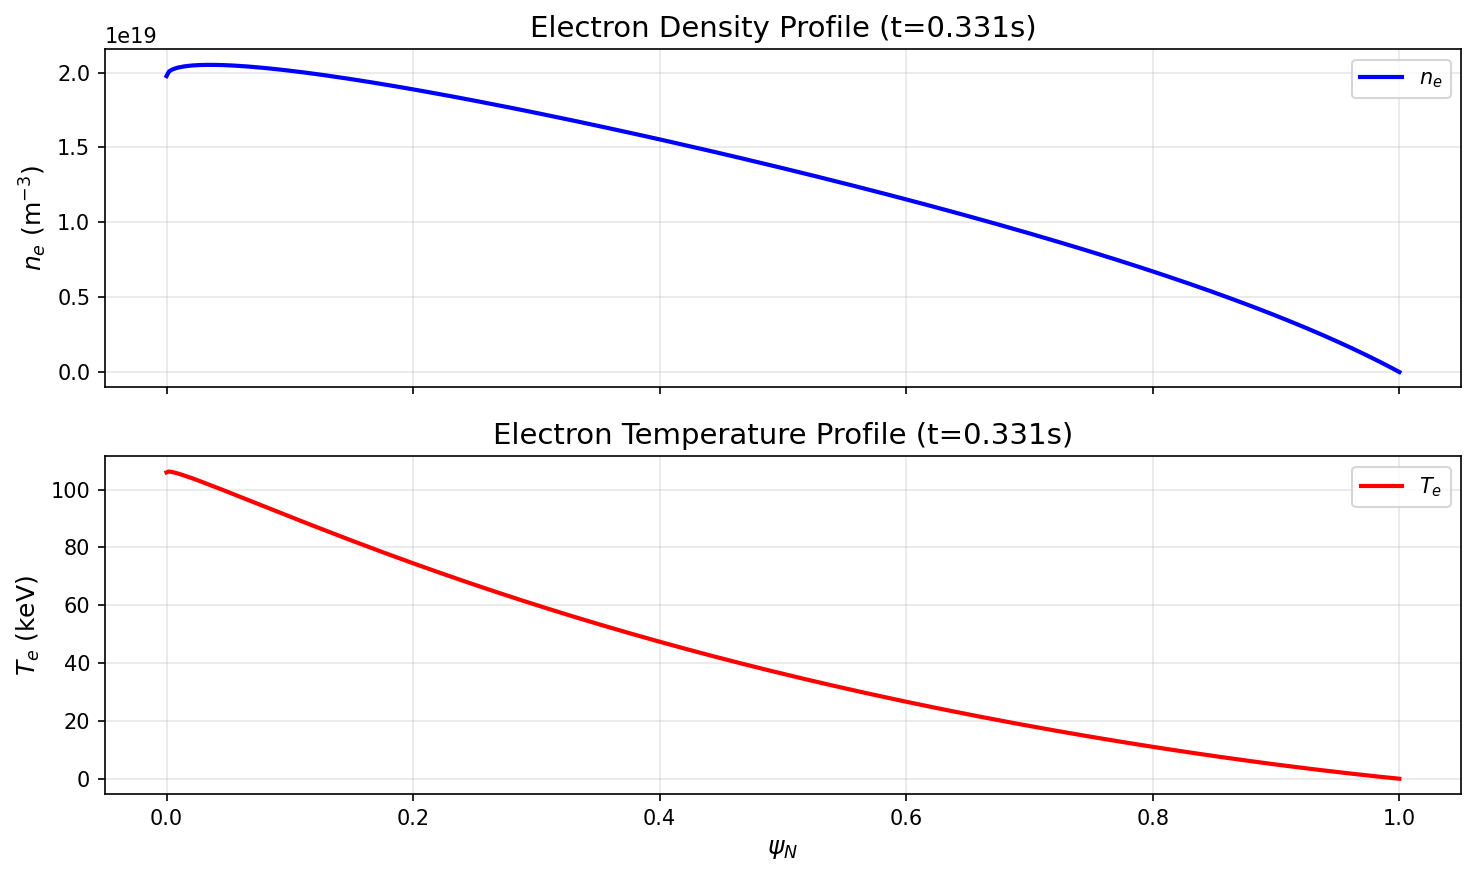


Plotting 2D electron density profile...


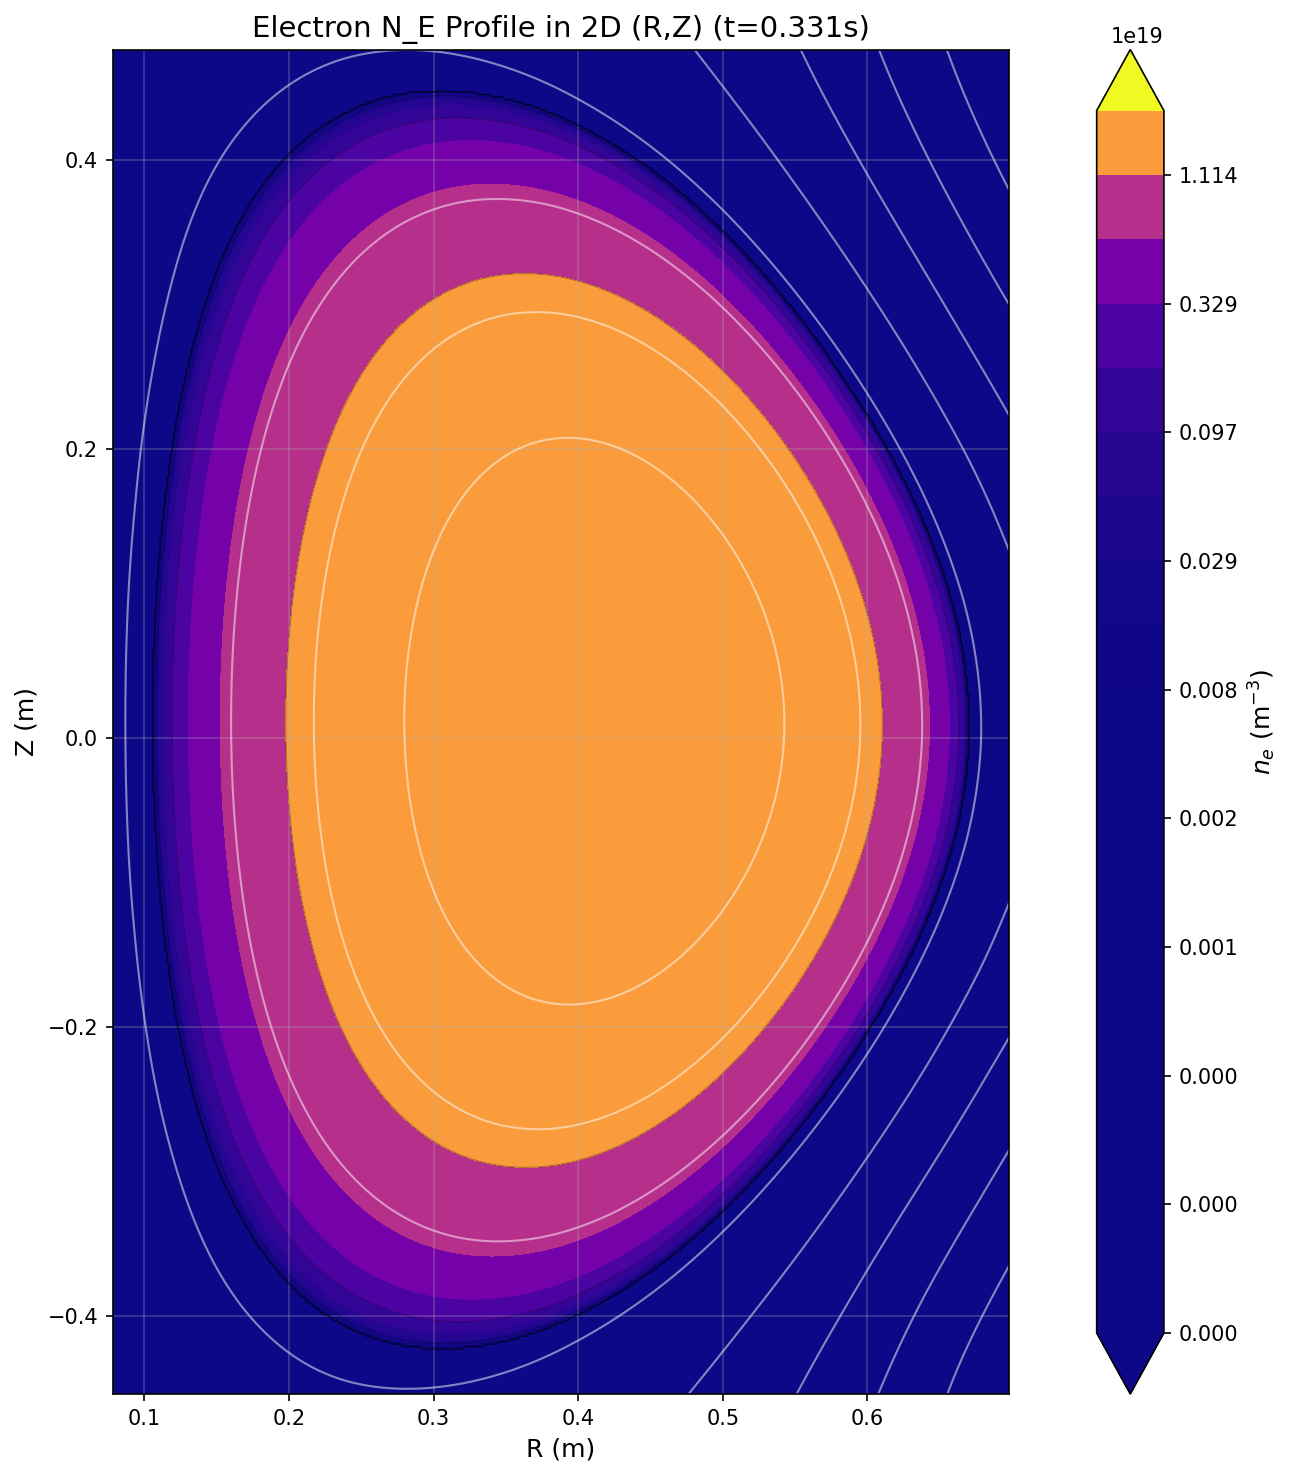


Plotting 2D electron temperature profile...


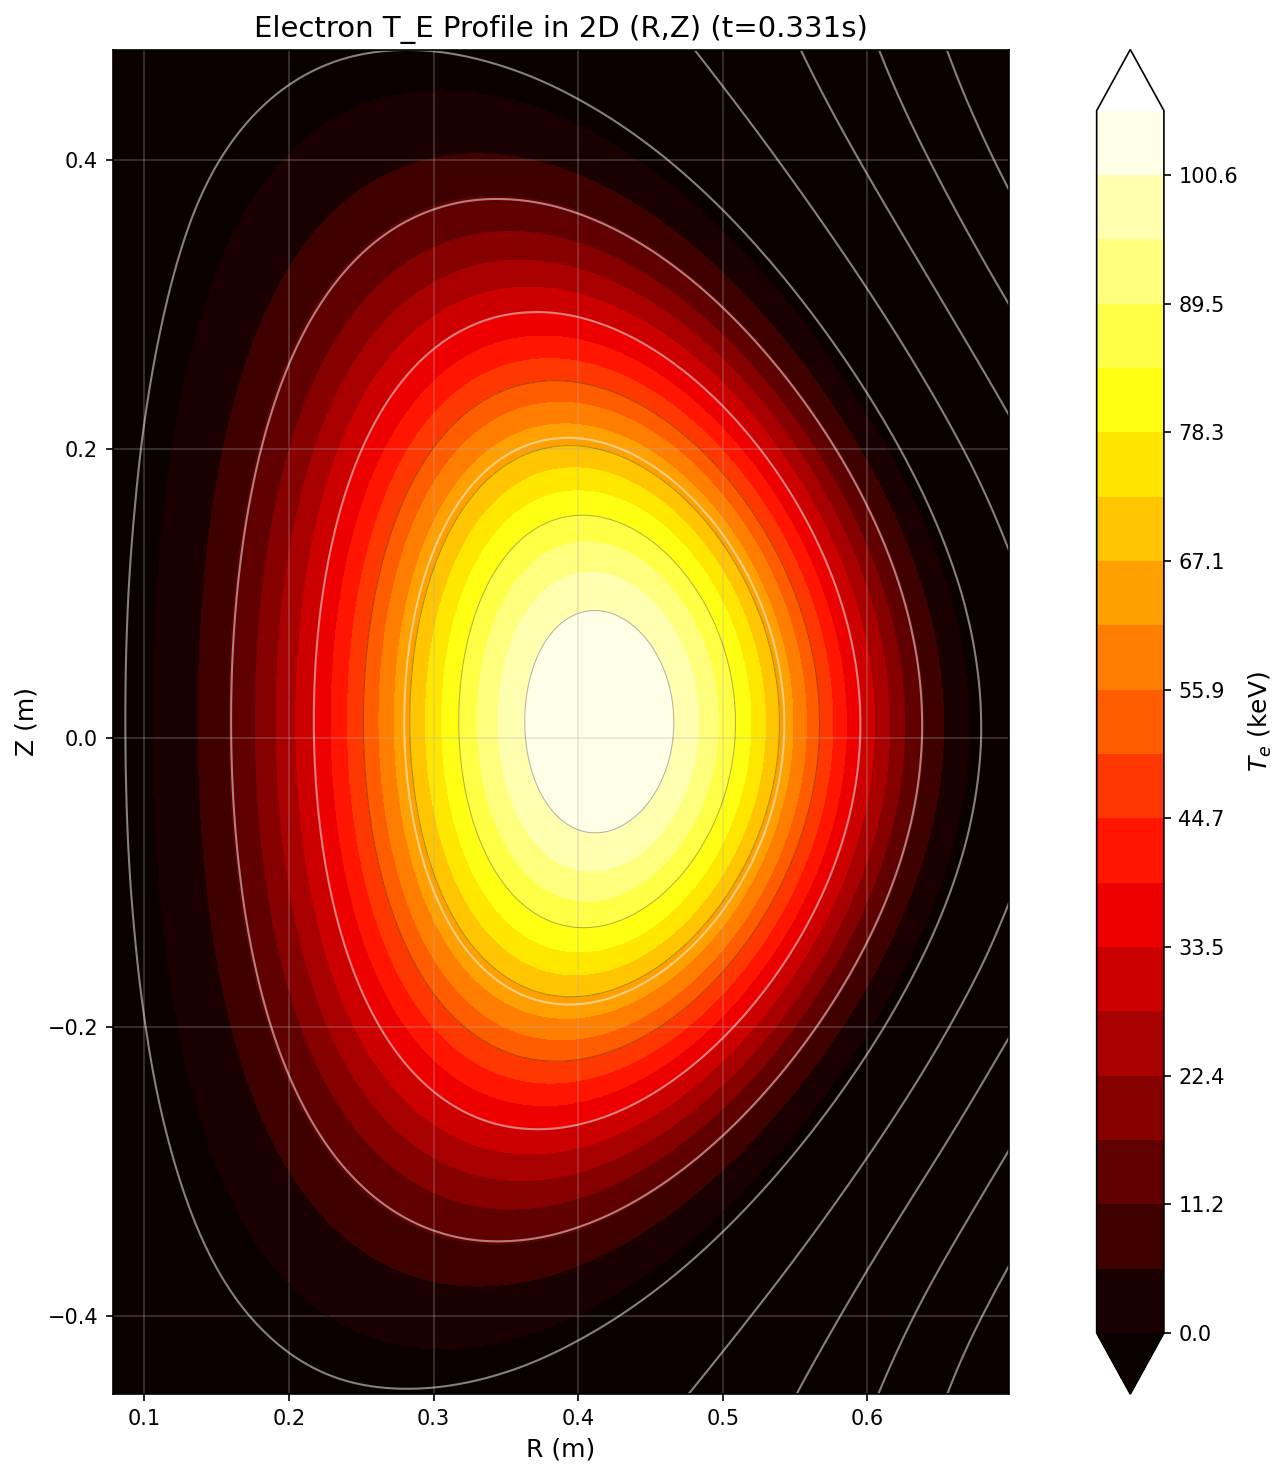


Plotting 2D equilibrium profiles...


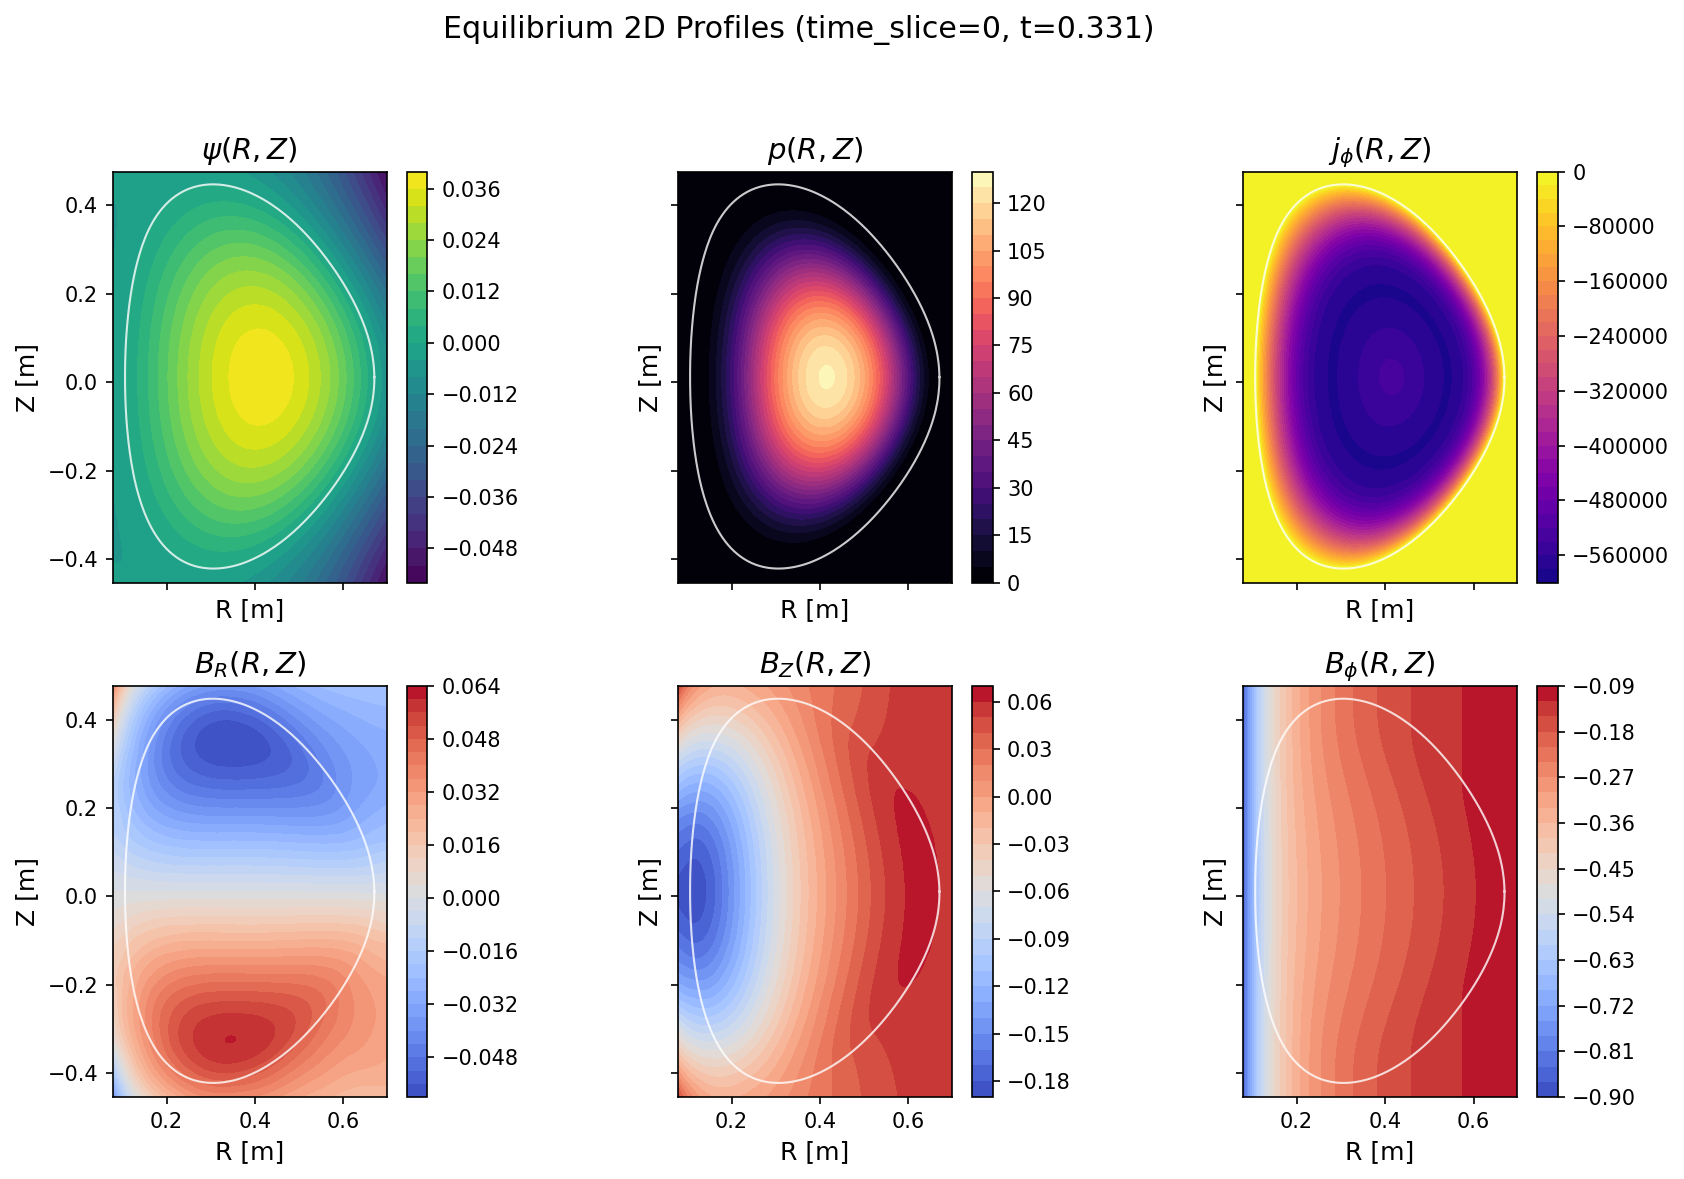

(<Figure size 1800x1200 with 12 Axes>,
 array([[<Axes: title={'center': '$\\psi(R,Z)$'}, xlabel='R [m]', ylabel='Z [m]'>,
         <Axes: title={'center': '$p(R,Z)$'}, xlabel='R [m]', ylabel='Z [m]'>,
         <Axes: title={'center': '$j_{\\phi}(R,Z)$'}, xlabel='R [m]', ylabel='Z [m]'>],
        [<Axes: title={'center': '$B_R(R,Z)$'}, xlabel='R [m]', ylabel='Z [m]'>,
         <Axes: title={'center': '$B_Z(R,Z)$'}, xlabel='R [m]', ylabel='Z [m]'>,
         <Axes: title={'center': '$B_{\\phi}(R,Z)$'}, xlabel='R [m]', ylabel='Z [m]'>]],
       dtype=object))

In [45]:
# Visualize 
for i in range(len(ods['core_profiles.profiles_1d'])):
    ods[f'core_profiles.profiles_1d.{i}.electrons.density'] = ods[f'core_profiles.profiles_1d.{i}.electrons.density_thermal'] 

# Plot electron profiles
vaft.plot.plot_electron_psi_profile(ods, time_slice=0, figsize=(10, 6))



# Plot 2D electron profiles
print("\nPlotting 2D electron density profile...")
vaft.plot.plot_electron_2d_profile(ods, option='n_e', time_slice=0, figsize=(12, 10))

print("\nPlotting 2D electron temperature profile...")
vaft.plot.plot_electron_2d_profile(ods, option='t_e', time_slice=0, figsize=(12, 10))

print("\nPlotting 2D equilibrium profiles...")
vaft.plot.equilibrium_2d_profiles(ods, time_slice=0, figsize=(12, 8))

In [46]:
# Step 2: Calculate power balance

from vaft.omas import compute_power_balance

# Calculate power balance for all time slices
power_balance = compute_power_balance(ods, time_slice=None)

# Display power balance results
print("\nPower Balance Results:")
print(power_balance)


Power Balance Results:
{'time': array([0.331, 0.334, 0.335, 0.337]), 'V_loop': array([0., 0., 0., 0.]), 'V_ind': array([ 90.73545151,  25.30804422,  28.86265274, 267.82762044]), 'V_res': array([ -90.73545151,  -25.30804422,  -28.86265274, -267.82762044]), 'P_ohm_flux': array([14301834.6505491 ,  2642592.46520457,  3096941.73430305,
       11778468.39606301]), 'P_ohm_diss': array([2594570.51322353,  307043.88691522,  186805.8968181 ,
       2594570.51322353]), 'P_aux': array([0., 0., 0., 0.]), 'P_heat': array([2594570.51322353,  307043.88691522,  186805.8968181 ,
       2594570.51322353]), 'P_rad': array([0., 0., 0., 0.]), 'dWdt': array([-14301834.6505491 ,  -2642592.46520457,  -3096941.73430305,
       -11778468.39606301]), 'P_loss': array([16896405.16377263,  2949636.35211979,  3283747.63112115,
       14373038.90928655])}


In [47]:
# Calculate confinement time parameters
from vaft.omas import compute_confiment_time_paramters
from vaft.omas import update_core_profiles_global_quantities_volume_average

# Update volume-averaged quantities if needed
try:
    update_core_profiles_global_quantities_volume_average(ods)
    print("Volume-averaged quantities updated.")
except Exception as e:
    print(f"Warning: Could not update volume averages: {e}")

# Calculate confinement time parameters for each time slice
Z_eff = 2.0  # Effective charge
M = 1.0      # Average ion mass [amu]

n_eq = len(ods['equilibrium']['time_slice'])
tau_IPB89_list = []
tau_H98y2_list = []
tau_NSTX_list = []
H_factor_list = []
tau_exp_list = []
time_list = []

print(f"\nCalculating confinement time parameters for {n_eq} time slices...")

for time_slice in range(n_eq):
    try:
        tau_IPB89, tau_H98y2, tau_NSTX, H_factor, tau_exp = compute_confiment_time_paramters(
            ods, time_slice=time_slice, Z_eff=Z_eff, M=M
        )
        
        eq_ts = ods['equilibrium']['time_slice'][time_slice]
        time_val = eq_ts.get('time', time_slice)
        
        tau_IPB89_list.append(tau_IPB89)
        tau_H98y2_list.append(tau_H98y2)
        tau_NSTX_list.append(tau_NSTX)
        H_factor_list.append(H_factor)
        tau_exp_list.append(tau_exp)
        time_list.append(time_val)
        
        print(f"  Time slice {time_slice} (t={time_val:.4f}s): τ_E,exp={tau_exp*1e3:.3f} ms, τ_E,H98y2={tau_H98y2*1e3:.3f} ms, H={H_factor:.3f}")
        
    except Exception as e:
        print(f"  Warning: Could not calculate for time_slice {time_slice}: {e}")
        continue

tau_IPB89_arr = np.array(tau_IPB89_list)
tau_H98y2_arr = np.array(tau_H98y2_list)
tau_NSTX_arr = np.array(tau_NSTX_list)
H_factor_arr = np.array(H_factor_list)
tau_exp_arr = np.array(tau_exp_list)
time_arr = np.array(time_list)

print(f"\nSummary:")
print(f"  Average τ_E,exp: {np.mean(tau_exp_arr)*1e3:.3f} ms")
print(f"  Average τ_E,H98y2: {np.mean(tau_H98y2_arr)*1e3:.3f} ms")
print(f"  Average H-factor: {np.mean(H_factor_arr):.3f}")


Calculating confinement time parameters for 4 time slices...
                                                                        ^^^^^^^^^^^
Did you mean: global_quantities, boundary, boundary_separatrix, profiles_2d, profiles_1d, ...
                                                                        ^^^^^^^^^^^
Did you mean: global_quantities, boundary, boundary_separatrix, profiles_2d, profiles_1d, ...
                                                                        ^^^^^^^^^^^
Did you mean: global_quantities, boundary, boundary_separatrix, profiles_2d, profiles_1d, ...
                                                                        ^^^^^^^^^^^
Did you mean: global_quantities, boundary, boundary_separatrix, profiles_2d, profiles_1d, ...

Summary:
  Average τ_E,exp: nan ms
  Average τ_E,H98y2: nan ms
  Average H-factor: nan



=== Step 6: Confinement Time Comparison ===


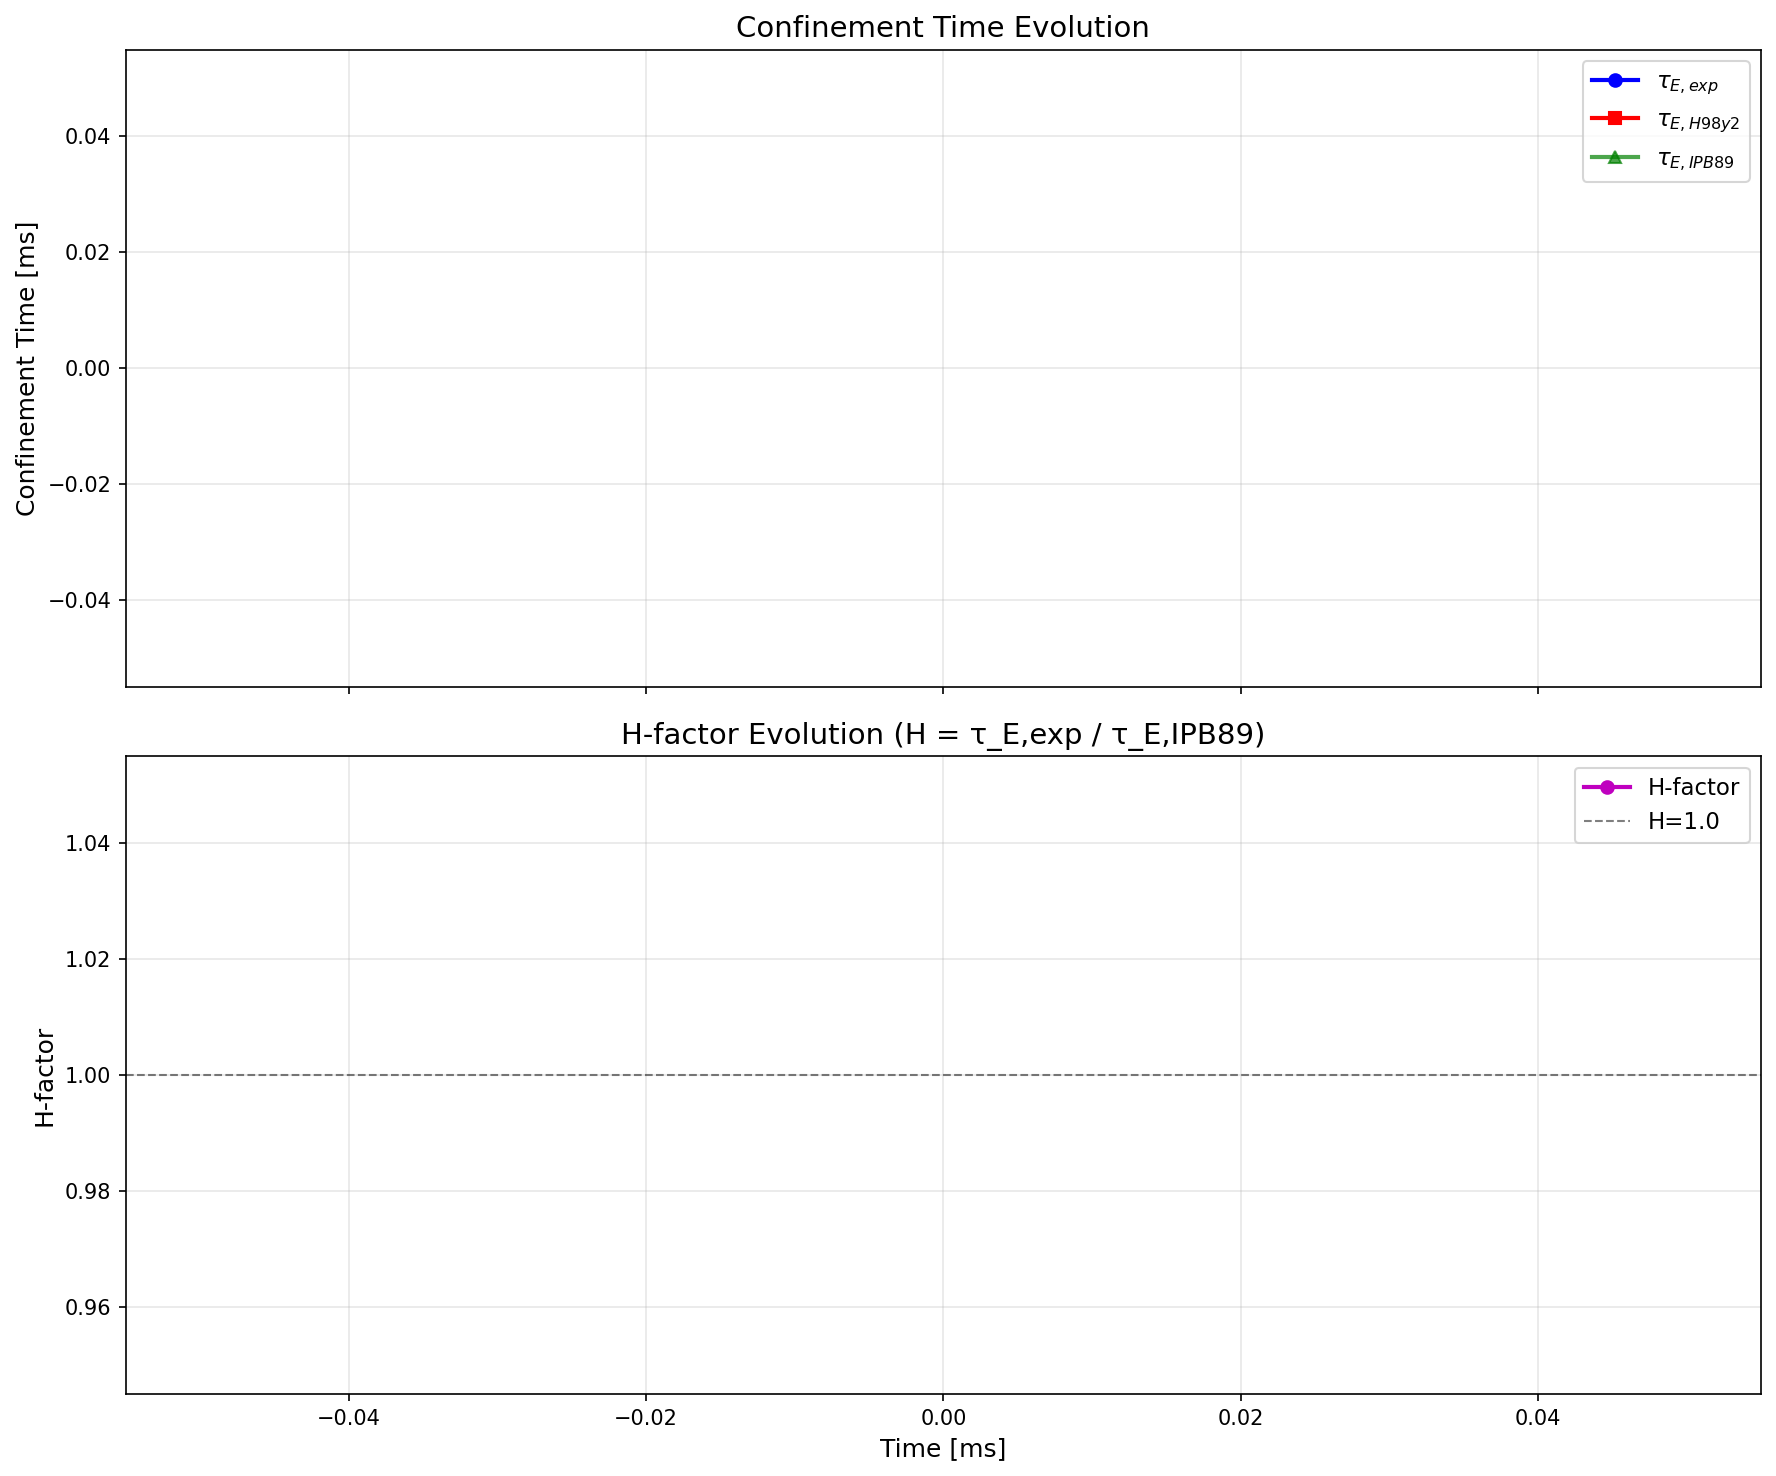

ValueError: zero-size array to reduction operation minimum which has no identity

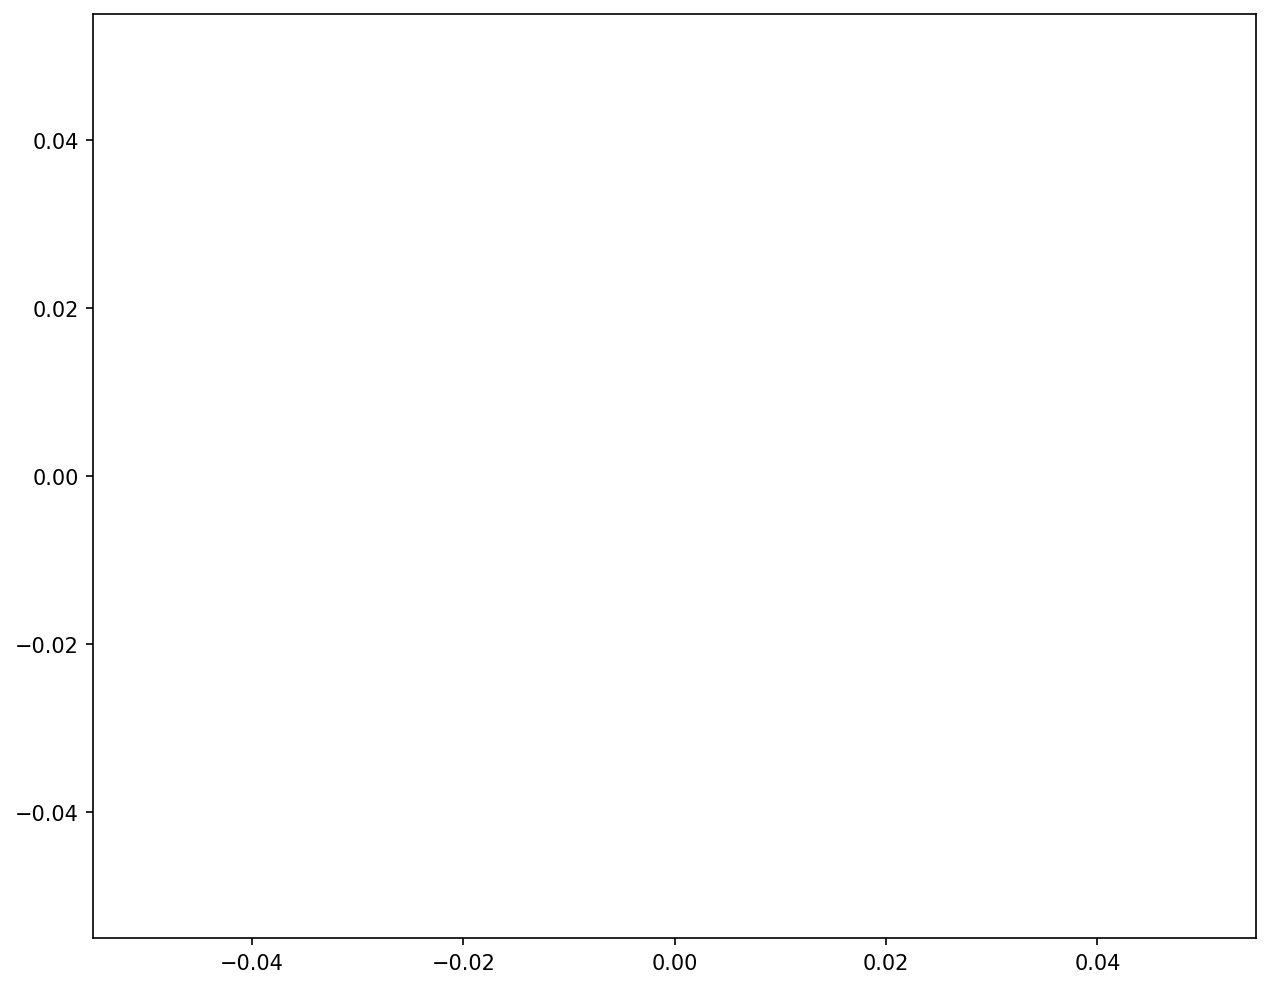

In [48]:
# Final comparison plot - τ_E,exp vs τ_E,H98y2
print("\n=== Step 6: Confinement Time Comparison ===")

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Time evolution of confinement times
axs[0].plot(time_arr * 1e3, tau_exp_arr * 1e3, 'b-o', label=r'$\tau_{E,exp}$', linewidth=2, markersize=6)
axs[0].plot(time_arr * 1e3, tau_H98y2_arr * 1e3, 'r-s', label=r'$\tau_{E,H98y2}$', linewidth=2, markersize=6)
axs[0].plot(time_arr * 1e3, tau_IPB89_arr * 1e3, 'g-^', label=r'$\tau_{E,IPB89}$', linewidth=2, markersize=6, alpha=0.7)
axs[0].set_ylabel('Confinement Time [ms]', fontsize=12)
axs[0].set_title('Confinement Time Evolution', fontsize=14)
axs[0].legend(fontsize=11, loc='best')
axs[0].grid(True, alpha=0.3)

# Plot 2: H-factor evolution
axs[1].plot(time_arr * 1e3, H_factor_arr, 'm-o', label='H-factor', linewidth=2, markersize=6)
axs[1].axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='H=1.0')
axs[1].set_xlabel('Time [ms]', fontsize=12)
axs[1].set_ylabel('H-factor', fontsize=12)
axs[1].set_title('H-factor Evolution (H = τ_E,exp / τ_E,IPB89)', fontsize=14)
axs[1].legend(fontsize=11, loc='best')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot: τ_E,exp vs τ_E,H98y2
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot
scatter = ax.scatter(tau_H98y2_arr * 1e3, tau_exp_arr * 1e3, 
                     c=time_arr * 1e3, cmap='viridis', s=100, alpha=0.7, edgecolors='k', linewidths=1)

# Add 1:1 line
min_val = min(np.min(tau_H98y2_arr), np.min(tau_exp_arr)) * 1e3
max_val = max(np.max(tau_H98y2_arr), np.max(tau_exp_arr)) * 1e3
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line', alpha=0.7)

# Linear fit
if len(tau_H98y2_arr) > 1:
    valid_mask = np.isfinite(tau_H98y2_arr) & np.isfinite(tau_exp_arr)
    if np.sum(valid_mask) > 1:
        coeffs = np.polyfit(tau_H98y2_arr[valid_mask] * 1e3, tau_exp_arr[valid_mask] * 1e3, 1)
        fit_line = np.poly1d(coeffs)
        x_fit = np.linspace(min_val, max_val, 100)
        ax.plot(x_fit, fit_line(x_fit), 'b-', linewidth=2, label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.3f}', alpha=0.8)
        
        # Calculate correlation coefficient
        corr = np.corrcoef(tau_H98y2_arr[valid_mask] * 1e3, tau_exp_arr[valid_mask] * 1e3)[0, 1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel(r'$\tau_{E,H98y2}$ [ms]', fontsize=14)
ax.set_ylabel(r'$\tau_{E,exp}$ [ms]', fontsize=14)
ax.set_title('Experimental vs H98y2 Confinement Time', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time [ms]', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nComparison Statistics:")
print(f"  Mean τ_E,exp: {np.mean(tau_exp_arr)*1e3:.3f} ± {np.std(tau_exp_arr)*1e3:.3f} ms")
print(f"  Mean τ_E,H98y2: {np.mean(tau_H98y2_arr)*1e3:.3f} ± {np.std(tau_H98y2_arr)*1e3:.3f} ms")
print(f"  Mean H-factor: {np.mean(H_factor_arr):.3f} ± {np.std(H_factor_arr):.3f}")
if len(tau_H98y2_arr) > 1:
    valid_mask = np.isfinite(tau_H98y2_arr) & np.isfinite(tau_exp_arr)
    if np.sum(valid_mask) > 1:
        ratio = tau_exp_arr[valid_mask] / tau_H98y2_arr[valid_mask]
        print(f"  Mean τ_E,exp / τ_E,H98y2: {np.mean(ratio):.3f} ± {np.std(ratio):.3f}")

# Statistical Analysis of Confinement Time Scaling

이 섹션은 전체 데이터셋에 대한 통계적 분석을 수행합니다:
1. 엑셀 파일에서 파라미터 데이터 로드
2. 로그 변환 및 OLS 회귀 분석
3. 결과 시각화 및 해석

In [ ]:
# Step 1: Generate core profiles history Excel file (if not exists)
# This step extracts parameters from ODS files and saves to Excel

import os
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'workflow', 'automatic_pipeline_3_data_summary'))
import gen_core_profiles_history
import statsmodels as stats

excel_file = "core_profiles_history.xlsx"

if not os.path.exists(excel_file):
    print("Generating core profiles history Excel file...")
    print("This may take a while as it processes all core_profile shots...")
    df_history = gen_core_profiles_history.generate_core_profiles_history_excel(max_shots=None)
    print(f"\nExcel file generated: {excel_file}")
else:
    print(f"Excel file already exists: {excel_file}")
    print("Skipping generation step.")

In [ ]:
print("="*60)
print("Loading data from Excel file...")
print("="*60)

df = stats.load_data_from_excel(excel_file)

print(f"\n✓ Loaded {len(df)} data points")
print(f"  Number of unique shots: {df['shot'].nunique()}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData summary:")
print(df.describe())
print(f"\nFirst few rows:")
print(df.head())

In [ ]:
print("="*60)
print("Performing OLS Regression Analysis")
print("="*60)

# Define engineering parameters
eng_params = ['Ip_MA', 'Bt_T', 'Ploss_MW', 'ne_19m3', 'R_m', 'a_m', 'kappa']
target_param = 'tauE_s'

print(f"\nEngineering parameters: {eng_params}")
print(f"Target parameter: {target_param}")
print()

results = stats.perform_ols_regression(df, eng_params, target_param)

# Display summary
print("\n" + "="*60)
print("Regression Summary")
print("="*60)
print(f"R-squared: {results.rsquared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")
print(f"Number of observations: {len(results.fitted_values)}")

print(f"\nCoefficients (Scaling Law Exponents):")
summary = results.get_summary()
print(summary.to_string())

exponents = results.get_exponents()
print(f"\n" + "="*60)
print("Scaling Law Exponents")
print("="*60)
for param, exp in exponents.items():
    print(f"  {param:12s}: {exp:8.4f}")

significance = stats.analyze_significance(results, alpha=0.05)
print(f"\n" + "="*60)
print("Statistical Significance (α = 0.05)")
print("="*60)
for param, is_sig in significance.items():
    pval = results.pvalues.get(f'ln_{param}', np.nan)
    status = "✓ Significant" if is_sig else "✗ Not significant"
    print(f"  {param:12s}: {status:20s} (p-value: {pval:.4f})")

In [ ]:
# Step 4: Compute performance metrics

metrics = stats.compute_metrics(results, df, target_param)

print("=== Model Performance Metrics ===")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

In [ ]:
# Step 5: Visualize results

# Plot 1: Overall fitting results and residuals
print("Plotting overall fitting results...")
fig1 = vaft.plot.plot_scaling_fit(results, df, target_param)
plt.show()

In [ ]:
# Plot 2: Individual parameter effects
print("Plotting individual parameter effects...")
log_df = results.log_df
fig2 = vaft.plot.plot_individual_parameter_effects(log_df, eng_params, target_param)
plt.show()

In [ ]:
# Plot 3: Correlation heatmap
print("Plotting correlation heatmap...")
fig3 = vaft.plot.plot_correlation_heatmap(log_df, eng_params, target_param)
if fig3 is not None:
    plt.show()

In [ ]:
# Plot 4: Regression summary (coefficients and p-values)
print("Plotting regression summary...")
fig4 = vaft.plot.plot_regression_summary(results)
plt.show()

In [ ]:
# Physical validation and interpretation
print("="*60)
print("Physical Validation and Interpretation")
print("="*60)

print("\nComparing with known scaling laws:")
print("(Reference: IPB98(y,2) scaling law)")

# Expected ranges for IPB98(y,2) (approximate)
expected_ranges = {
    'Ip_MA': (0.9, 1.0),
    'Bt_T': (0.1, 0.2),
    'Ploss_MW': (-0.7, -0.6),
    'ne_19m3': (0.4, 0.5),
    'R_m': (1.3, 1.5),
    'a_m': None,  # Not in standard form
    'kappa': (0.5, 0.7)
}

print("\nExponent Comparison:")
print("-" * 60)
for param in eng_params:
    if param in exponents:
        exp = exponents[param]
        if param in expected_ranges and expected_ranges[param] is not None:
            exp_min, exp_max = expected_ranges[param]
            if exp_min <= exp <= exp_max:
                status = "✓ Within expected range"
            else:
                status = f"✗ Outside expected range ({exp_min:.2f} - {exp_max:.2f})"
            print(f"  {param:12s}: {exp:8.4f}  {status}")
        else:
            print(f"  {param:12s}: {exp:8.4f}  (no reference range)")

print("\n" + "="*60)
print("Model Interpretation")
print("="*60)
print(f"\nModel Performance:")
print(f"  - R² (explained variance): {results.rsquared*100:.1f}%")
print(f"  - Adjusted R²: {results.rsquared_adj*100:.1f}%")
print(f"  - Mean relative error: {metrics.get('Mean_Relative_Error_%', np.nan):.2f}%")

# Significant parameters
sig_params = [p for p, is_sig in significance.items() if is_sig]
non_sig_params = [p for p, is_sig in significance.items() if not is_sig]

print(f"\nStatistically Significant Parameters (p < 0.05):")
if sig_params:
    for param in sig_params:
        pval = results.pvalues.get(f'ln_{param}', np.nan)
        exp = exponents.get(param, np.nan)
        print(f"  ✓ {param:12s}: exponent = {exp:8.4f}, p-value = {pval:.4f}")
else:
    print("  (None)")

if non_sig_params:
    print(f"\nNon-Significant Parameters:")
    for param in non_sig_params:
        pval = results.pvalues.get(f'ln_{param}', np.nan)
        exp = exponents.get(param, np.nan)
        print(f"  ✗ {param:12s}: exponent = {exp:8.4f}, p-value = {pval:.4f}")
    print("\n  Note: These parameters may not have significant impact on")
    print("        confinement time in this dataset, or may be correlated")
    print("        with other parameters (multicollinearity).")

## **Part 3:**
shot #33916